In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

In [3]:
#read in data (2_ZFBS_tuning_BCB or _AAA)
df = pd.read_csv('2_ZFBS_tuning_BCB.csv',header=None)

df = df.rename(columns={0: '∆G', 
                        1: 'A', 
                        2: 'B', 
                        3: 'AB non-coop', 
                        4: 'AB coop', 
                        5: 'A err', 
                        6: 'B err', 
                        7: 'AB nc err', 
                        8: 'AB c err'})

df['Kd'] = np.exp(df['∆G']/0.5921)*1e9

#sort data - lowest to highest Kd
a = np.array(df['Kd'])
b = np.array(df['A'])
c = np.array(df['A err'])
d = np.array(df['B'])
e = np.array(df['B err'])
f = np.array(df['AB non-coop'])
g = np.array(df['AB nc err'])
h = np.array(df['AB coop'])
i = np.array(df['AB c err'])

abc = np.column_stack((a, b, c, d, e, f, g, h, i))

col = 0
data = abc[np.argsort(abc[:, col])]

Kd = data[:, 0]
FR_a = data[:, 1]
FRerr_a = data[:, 2]
FR_b = data[:, 3]
FRerr_b = data[:, 4]
FR_abnc = data[:, 5]
FRerr_abnc = data[:, 6]
FR_abc = data[:, 7]
FRerr_abc = data[:, 8]

In [4]:
def FR_double_1(C0, C1, Erp1, x):
    """Model for fold repression for a heterodimer --> single ZF present"""
    UR = 1 / (1 + C0)
    Freg1 = 1 + (C1/x)*np.exp(-Erp1)
    Freg2 = 1 + C1/x
    Freg = Freg1 / Freg2
    R = 1/(1 + C0/Freg)
    return UR/R

In [5]:
def FR_double_2(C0, C1, C2, Erp1, Erp2, x):
    """Model for fold repression for a heterodimer --> non-coop 2 ZFs present"""
    UR = 1 / (1 + C0)
    Freg1 = 1 + (C1/x)*np.exp(-Erp1) + C2*np.exp(-Erp2) + C2*(C1/x)*np.exp(-(Erp1 + Erp2))
    Freg2 = 1 + C1/x + C2 + C2*(C1/x)
    Freg = Freg1 / Freg2
    R = 1/(1 + C0/Freg)
    return UR/R

In [6]:
def FR_double_3(C0, C1, C2, Erp1, Erp2, Er, x):
    """Model for fold repression for a heterodimer --> coop 2 ZFs present"""
    UR = 1 / (1 + C0)
    Freg1 = 1 + (C1/x)*np.exp(-Erp1) + C2*np.exp(-Erp2) + C2*(C1/x)*np.exp(-(Erp1 + Erp2))*np.exp(-Er)
    Freg2 = 1 + C1/x + C2 + C2*(C1/x)*np.exp(-Er)
    Freg = Freg1 / Freg2
    R = 1/(1 + C0/Freg)
    return UR/R

In [10]:
#fit single
def lnlike_1(theta, x, y1, yerr1):
    """calculate log likelihood"""
    C0, C1, Erp1 = theta
    
    ypred1 = FR_double_1(C0, C1, Erp1, x)
    
    inv_sigma2_1 = 1/(yerr1**2)
    
    X1 = np.sum((ypred1-y1)**2 * inv_sigma2_1 - np.log(inv_sigma2_1))

    return -0.5 * X1

def lnprior_1(theta, y1, yerr1):
    """calculate log priors"""
    C0, C1, Erp1 = theta
    if not (0 < C0 and 0 < C1 and 0 < Erp1): 
        return -np.inf # Hard-cutoff for positive value constraint

    mu1 = 5e-3
    sigma1 = 5e-3
    log_Pr1 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma1)) - 0.5*(C0 - mu1)**2/sigma1**2
    
    mu2 = 5e2
    sigma2 = 5e2
    log_Pr2 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma2)) - 0.5*(C1 - mu2)**2/sigma2**2
    
    mu3 = 10
    sigma3 = 10
    log_Pr3 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma3)) - 0.5*(Erp1 - mu3)**2/sigma3**2
    
    return log_Pr1 + log_Pr2 + log_Pr3 

def lnprob_1(theta, x, y1, yerr1):
    """calculate log probability"""
    lp = lnprior_1(theta, y1, yerr1)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_1(theta, x, y1, yerr1)


In [16]:
#fit non-coop
def lnlike_2(theta, x, y1, yerr1):
    """calculate log likelihood"""
    C0, C1, C2, Erp1, Erp2 = theta
    
    ypred1 = FR_double_2(C0, C1, C2, Erp1, Erp2, x)
    
    inv_sigma2_1 = 1/(yerr1**2)
    
    X1 = np.sum((ypred1-y1)**2 * inv_sigma2_1 - np.log(inv_sigma2_1))

    return -0.5 * X1

def lnprior_2(theta, y1, yerr1):
    """calculate log priors"""
    C0, C1, C2, Erp1, Erp2 = theta
    if not (0 < C0 and 0 < C1 and 0 < C2 and 0 < Erp1 and 0 < Erp2): 
        return -np.inf # Hard-cutoff for positive value constraint

    mu1 = 5e-3
    sigma1 = 5e-3
    log_Pr1 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma1)) - 0.5*(C0 - mu1)**2/sigma1**2
    
    mu2 = 1e2
    sigma2 = 1e2
    log_Pr2 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma2)) - 0.5*(C1 - mu2)**2/sigma2**2
    
    mu3 = 1e2
    sigma3 = 1e2
    log_Pr3 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma3)) - 0.5*(C2 - mu3)**2/sigma3**2
    
    mu4 = 5
    sigma4 = 5
    log_Pr4 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma4)) - 0.5*(Erp1 - mu4)**2/sigma4**2
    
    mu5 = 5
    sigma5 = 5
    log_Pr5 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma5)) - 0.5*(Erp2 - mu5)**2/sigma5**2
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4 + log_Pr5

def lnprob_2(theta, x, y1, yerr1):
    """calculate log probability"""
    lp = lnprior_2(theta, y1, yerr1)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_2(theta, x, y1, yerr1)


In [22]:
#fit coop
def lnlike_3(theta, x, y1, yerr1):
    """calculate log likelihood"""
    C0, C1, C2, Erp1, Erp2, Er = theta
    
    ypred1 = FR_double_3(C0, C1, C2, Erp1, Erp2, Er, x)
    
    inv_sigma2_1 = 1/(yerr1**2)
    
    X1 = np.sum((ypred1-y1)**2 * inv_sigma2_1 - np.log(inv_sigma2_1))

    return -0.5 * X1

def lnprior_3(theta, y1, yerr1):
    """calculate log priors"""
    C0, C1, C2, Erp1, Erp2, Er = theta
    if not (0 < C0 and 0 < C1 and 0 < C2 and 0 < Erp1 and 0 < Erp2): 
        return -np.inf # Hard-cutoff for positive value constraint

    mu1 = 5e-3
    sigma1 = 5e-2
    log_Pr1 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma1)) - 0.5*(C0 - mu1)**2/sigma1**2
    
    mu2 = 9e1
    sigma2 = 9
    log_Pr2 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma2)) - 0.5*(C1 - mu2)**2/sigma2**2
    
    mu3 = 5e1
    sigma3 = 5
    log_Pr3 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma3)) - 0.5*(C2 - mu3)**2/sigma3**2
    
    mu4 = 10
    sigma4 = 1 
    log_Pr4 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma4)) - 0.5*(Erp1 - mu4)**2/sigma4**2
    
    mu5 = 2
    sigma5 = 1
    log_Pr5 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma5)) - 0.5*(Erp2 - mu5)**2/sigma5**2
    
    mu6 = -1
    sigma6 = 1
    log_Pr6 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma6)) - 0.5*(Er - mu6)**2/sigma6**2
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4 + log_Pr5 + log_Pr6

def lnprob_3(theta, x, y1, yerr1):
    """calculate log probability"""
    lp = lnprior_3(theta, y1, yerr1)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_3(theta, x, y1, yerr1)


In [11]:
#fit single, non-cooperative and cooperative simultaneously
def lnlike(theta, x, y1, yerr1, y2, yerr2, y3, yerr3):
    """calculate log likelihood"""
    C0, C1, C2, Erp1, Erp2, Er = theta
    
    ypred1 = FR_double_1(C0, C1, Erp1, x)
    ypred2 = FR_double_2(C0, C1, C2, Erp1, Erp2, x)
    ypred3 = FR_double_3(C0, C1, C2, Erp1, Erp2, Er, x)
    
    inv_sigma2_1 = 1/(yerr1**2)
    inv_sigma2_2 = 1/(yerr2**2)
    inv_sigma2_3 = 1/(yerr3**2)
    
    X1 = np.sum((ypred1-y1)**2 * inv_sigma2_1 - np.log(inv_sigma2_1))
    X2 = np.sum((ypred2-y2)**2 * inv_sigma2_2 - np.log(inv_sigma2_2))
    X3 = np.sum((ypred3-y3)**2 * inv_sigma2_3 - np.log(inv_sigma2_3))
    
    return -0.5 * (X1 + X2 + X3)

def lnprior(theta, y1, yerr1, y2, yerr2, y3, yerr3):
    """calculate log priors"""
    C0, C1, C2, Erp1, Erp2, Er = theta
    if not (0 < C0 and 0 < C1 and 0 < C2 and 0 < Erp1 and 0 < Erp2): 
        return -np.inf # Hard-cutoff for positive value constraint

    mu1 = 1e-3
    sigma1 = 1e-3
    log_Pr1 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma1)) - 0.5*(C0 - mu1)**2/sigma1**2
    
    mu2 = 1e1
    sigma2 = 1e1
    log_Pr2 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma2)) - 0.5*(C1 - mu2)**2/sigma2**2
    
    mu3 = 1e1
    sigma3 = 1e1
    log_Pr3 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma3)) - 0.5*(C2 - mu3)**2/sigma3**2
    
    mu4 = 1
    sigma4 = 10
    log_Pr4 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma4)) - 0.5*(Erp1 - mu4)**2/sigma4**2
    
    mu5 = 1
    sigma5 = 10
    log_Pr5 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma5)) - 0.5*(Erp2 - mu5)**2/sigma5**2
    
    mu6 = -1
    sigma6 = 5
    log_Pr6 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma6)) - 0.5*(Er - mu6)**2/sigma6**2
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4 + log_Pr5 + log_Pr6

def lnprob(theta, x, y1, yerr1, y2, yerr2, y3, yerr3):
    """calculate log probability"""
    lp = lnprior(theta, y1, yerr1, y2, yerr2, y3, yerr3)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y1, yerr1, y2, yerr2, y3, yerr3)


In [11]:
ndim = 3
nwalkers = 50

pos = [np.array([5e-3*(1 + 1e-4*np.random.randn()),
                 5e2*(1 + 1e-4*np.random.randn()),
                 10*(1 + 1e-4*np.random.randn())
                ]) for i in range(nwalkers)] # Initialise walkers 


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_1, 
                                args=(Kd, FR_b, FRerr_b), 
                                threads=4)


In [17]:
ndim = 5
nwalkers = 50

pos = [np.array([5e-3*(1 + 1e-4*np.random.randn()),
                 1e2*(1 + 1e-4*np.random.randn()),
                 1e2*(1 + 1e-4*np.random.randn()),
                 5*(1 + 1e-4*np.random.randn()),
                 5*(1 + 1e-4*np.random.randn())
                ]) for i in range(nwalkers)] # Initialise walkers 


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_2, 
                                args=(Kd, FR_abnc, FRerr_abnc), 
                                threads=4)


In [23]:
ndim = 6
nwalkers = 50

pos = [np.array([4e-3*(1 + 1e-4*np.random.randn()),
                 9e1*(1 + 1e-4*np.random.randn()),
                 5e1*(1 + 1e-4*np.random.randn()),
                 7*(1 + 1e-4*np.random.randn()),
                 2*(1 + 1e-4*np.random.randn()),
                 -1*(1 + 1e-4*np.random.randn())
                ]) for i in range(nwalkers)] # Initialise walkers 


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_3, 
                                args=(Kd, FR_abc, FRerr_abc), 
                                threads=4)

In [12]:
ndim = 6
nwalkers = 50

pos = [np.array([1e-3*(1 + 1e-4*np.random.randn()),
                 1e1*(1 + 1e-4*np.random.randn()),
                 1e1*(1 + 1e-4*np.random.randn()),
                 1*(1 + 1e-4*np.random.randn()),
                 1*(1 + 1e-4*np.random.randn()),
                 -1*(1 + 1e-4*np.random.randn())
                ]) for i in range(nwalkers)] # Initialise walkers 


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(Kd, FR_a, FRerr_a, FR_abnc, FRerr_abnc, FR_abc, FRerr_abc), 
                                threads=4)


In [24]:
print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(pos, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(pos, 10000)

Running burn-in...
Running production...


(array([[ 7.25847883e-03,  9.39864959e+01,  4.89289468e+01,
          9.00101242e+00,  2.87133112e+00, -6.08963808e-01],
        [ 1.12354463e-01,  8.33993505e+01,  4.29272221e+01,
          1.00052159e+01,  2.54564140e-01, -4.65790775e-01],
        [ 1.51670045e-02,  7.76799657e+01,  5.35016852e+01,
          1.01441568e+01,  1.60042452e+00, -1.08558004e+00],
        [ 1.78204323e-02,  8.58894132e+01,  4.36414935e+01,
          1.04697987e+01,  1.77779608e+00, -8.39655294e-01],
        [ 2.63808163e-02,  7.95540092e+01,  4.82136076e+01,
          7.77591043e+00,  5.54708307e-01, -1.65859001e+00],
        [ 2.76522665e-02,  8.65479008e+01,  5.09183059e+01,
          9.59477378e+00,  1.82367431e+00, -1.87573434e-01],
        [ 4.74554995e-02,  8.65538042e+01,  4.31886018e+01,
          1.08528322e+01,  5.98843057e-01, -9.26268579e-01],
        [ 1.58030362e-02,  7.83478475e+01,  4.21406151e+01,
          1.05777940e+01,  1.51805965e+00, -1.36822695e+00],
        [ 3.54158064e-02,  9.729

In [14]:
samples = sampler.chain[:,:,:].reshape((-1,ndim))
samples_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

In [13]:
samples1 = sampler.chain[:,:,:].reshape((-1,ndim))
samples1_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

In [19]:
samples2 = sampler.chain[:,:,:].reshape((-1,ndim))
samples2_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

In [25]:
samples3 = sampler.chain[:,:,:].reshape((-1,ndim))
samples3_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

In [22]:
samples4 = sampler.chain[:,:,:].reshape((-1,ndim))
samples4_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

In [14]:
np.random.seed(0) # For reproducible outputs
modelscale=np.linspace(2, 25, 400)
numberofmodeltraces=1000

ypred1=np.zeros((len(modelscale),numberofmodeltraces))

i=0
for C0, C1, Erp1 in samples1_end[np.random.randint(len(samples1_end), size=numberofmodeltraces)]:
    ypred1[:, i] = FR_double_1(C0, C1, Erp1, modelscale)
    i+=1
    
# 2-sigma distributions
quant1=[np.mean(ypred1, axis=1)-2*np.std(ypred1, axis=1),
        np.mean(ypred1, axis=1),
        np.mean(ypred1, axis=1)+2*np.std(ypred1, axis=1)]


In [20]:
np.random.seed(0) # For reproducible outputs
modelscale=np.linspace(2, 25, 400)
numberofmodeltraces=1000

ypred2=np.zeros((len(modelscale),numberofmodeltraces))

i=0
for C0, C1, C2, Erp1, Erp2 in samples2_end[np.random.randint(len(samples2_end), size=numberofmodeltraces)]:
    ypred2[:, i] = FR_double_2(C0, C1, C2, Erp1, Erp2, modelscale)
    i+=1
    
# 2-sigma distributions
quant2=[np.mean(ypred2, axis=1)-2*np.std(ypred2, axis=1),
        np.mean(ypred2, axis=1),
        np.mean(ypred2, axis=1)+2*np.std(ypred2, axis=1)]


In [26]:
np.random.seed(0) # For reproducible outputs
modelscale=np.linspace(2, 25, 400)
numberofmodeltraces=1000

ypred3=np.zeros((len(modelscale),numberofmodeltraces))

i=0
for C0, C1, C2, Erp1, Erp2, Er in samples3_end[np.random.randint(len(samples3_end), size=numberofmodeltraces)]:
    ypred3[:, i] = FR_double_3(C0, C1, C2, Erp1, Erp2, Er, modelscale)
    i+=1
    
# 2-sigma distributions
quant3=[np.mean(ypred3, axis=1)-2*np.std(ypred3, axis=1),
        np.mean(ypred3, axis=1),
        np.mean(ypred3, axis=1)+2*np.std(ypred3, axis=1)]


In [15]:
np.random.seed(0) # For reproducible outputs
modelscale=np.linspace(2, 25, 400)
numberofmodeltraces=1000

ypred1=np.zeros((len(modelscale),numberofmodeltraces))
ypred2=np.zeros((len(modelscale),numberofmodeltraces))
ypred3=np.zeros((len(modelscale),numberofmodeltraces))

i=0
for C0, C1, C2, Erp1, Erp2, Er in samples_end[np.random.randint(len(samples_end), size=numberofmodeltraces)]:
    ypred1[:, i] = FR_double_1(C0, C1, Erp1, modelscale)
    ypred2[:, i] = FR_double_2(C0, C1, C2, Erp1, Erp2, modelscale)
    ypred3[:, i] = FR_double_3(C0, C1, C2, Erp1, Erp2, Er, modelscale)
    i+=1
    
# 2-sigma distributions
quant1=[np.mean(ypred1, axis=1)-2*np.std(ypred1, axis=1),
        np.mean(ypred1, axis=1),
        np.mean(ypred1, axis=1)+2*np.std(ypred1, axis=1)]

quant2=[np.mean(ypred2, axis=1)-2*np.std(ypred2, axis=1),
        np.mean(ypred2, axis=1),
        np.mean(ypred2, axis=1)+2*np.std(ypred2, axis=1)]

quant3=[np.mean(ypred3, axis=1)-2*np.std(ypred3, axis=1),
        np.mean(ypred3, axis=1),
        np.mean(ypred3, axis=1)+2*np.std(ypred3, axis=1)]


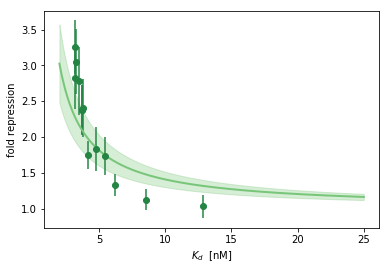

In [15]:
fig = plt.figure()

plt.fill_between(modelscale, quant1[0], quant1[2], color='#78c679', alpha=0.3)
plt.plot(modelscale, quant1[1], '-', color='#78c679', alpha=1, lw=2)


plt.errorbar(Kd, FR_b, yerr=FRerr_b, 
             fmt='o', color='#238443', label='ZF-BCB')

plt.xlabel('$K_d$  [nM]')
plt.ylabel('fold repression')

plt.savefig('heterodimerA_fit.pdf', dpi=150,transparent=True, bbox_inches='tight')

plt.show()

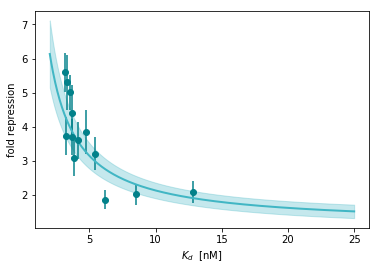

In [21]:
fig = plt.figure()

plt.fill_between(modelscale, quant2[0], quant2[2], color='#41b6c4', alpha=0.3)
plt.plot(modelscale, quant2[1], '-', color='#41b6c4', alpha=1, lw=2)

plt.errorbar(Kd, FR_abnc, yerr=FRerr_abnc, 
             fmt='o', color='#02818a')

plt.xlabel('$K_d$  [nM]')
plt.ylabel('fold repression')

plt.savefig('heterodimerA_nc_fit.pdf', dpi=150,transparent=True, bbox_inches='tight')

plt.show()

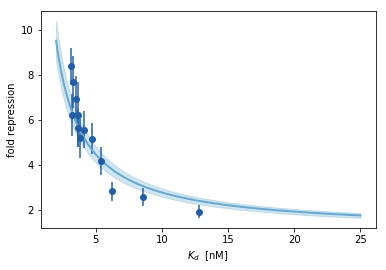

In [27]:
fig = plt.figure()

plt.fill_between(modelscale, quant3[0], quant3[2], color='#67a9cf', alpha=0.3)
plt.plot(modelscale, quant3[1], '-', color='#67a9cf', alpha=1, lw=2)

plt.errorbar(Kd, FR_abc, yerr=FRerr_abc, 
             fmt='o', color='#225ea8')

plt.xlabel('$K_d$  [nM]')
plt.ylabel('fold repression')

plt.savefig('heterodimerA_c_fit.pdf', dpi=150,transparent=True, bbox_inches='tight')

plt.show()

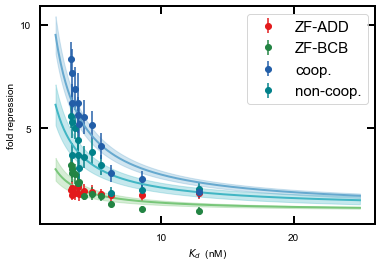

In [28]:
fig, ax = plt.subplots()

plt.fill_between(modelscale, quant1[0], quant1[2], color='#78c679', alpha=0.3)
plt.plot(modelscale, quant1[1], '-', color='#78c679', alpha=1, lw=2)

plt.fill_between(modelscale, quant2[0], quant2[2], color='#41b6c4', alpha=0.3)
plt.plot(modelscale, quant2[1], '-', color='#41b6c4', alpha=1, lw=2)

plt.fill_between(modelscale, quant3[0], quant3[2], color='#67a9cf', alpha=0.3)
plt.plot(modelscale, quant3[1], '-', color='#67a9cf', alpha=1, lw=2)

a = plt.errorbar(Kd, FR_a, yerr=FRerr_a, 
             fmt='o', color='#e31a1c', label='ZF-ADD')

b = plt.errorbar(Kd, FR_b, yerr=FRerr_b, 
             fmt='o', color='#238443', label='ZF-BCB')

nc = plt.errorbar(Kd, FR_abnc, yerr=FRerr_abnc, 
             fmt='o', color='#02818a', label='non-coop.')

c = plt.errorbar(Kd, FR_abc, yerr=FRerr_abc, 
             fmt='o', color='#225ea8', label='coop.')

plt.legend(handles=[a, b, c, nc], fontsize=15)

plt.xlabel('$K_d$  (nM)')
plt.ylabel('fold repression')


ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2) 

ax.tick_params(which='major', width=2, length=8, pad=9,direction='in',top=True,right=True)
ax.tick_params(which='minor', width=2, length=4, pad=9,direction='in',top=True,right=True)

figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. A5=8.27,5.83
font_options={'size':'24','family':'sans-serif','sans-serif':'Arial'}
plt.rc('figure', **figure_options)
plt.rc('font', **font_options)

plt.savefig('heterodimerB_fit.pdf', dpi=150,transparent=True, bbox_inches='tight')

plt.show()

Quantiles:
[(0.16, 0.005338522302016828), (0.5, 0.01638245679048804), (0.84, 0.04019468470783229)]
Quantiles:
[(0.16, 82.04376996949907), (0.5, 90.84057553288702), (0.84, 99.90519789588629)]
Quantiles:
[(0.16, 44.89786330259723), (0.5, 49.98808745628236), (0.84, 54.798792319597325)]
Quantiles:
[(0.16, 9.487876769215136), (0.5, 10.355709502572626), (0.84, 11.259161926344897)]
Quantiles:
[(0.16, 0.3538799341283613), (0.5, 1.0638562171829167), (0.84, 1.9770065983274372)]
Quantiles:
[(0.16, -2.03985044920607), (0.5, -1.4462276234917608), (0.84, -0.9119557714513642)]


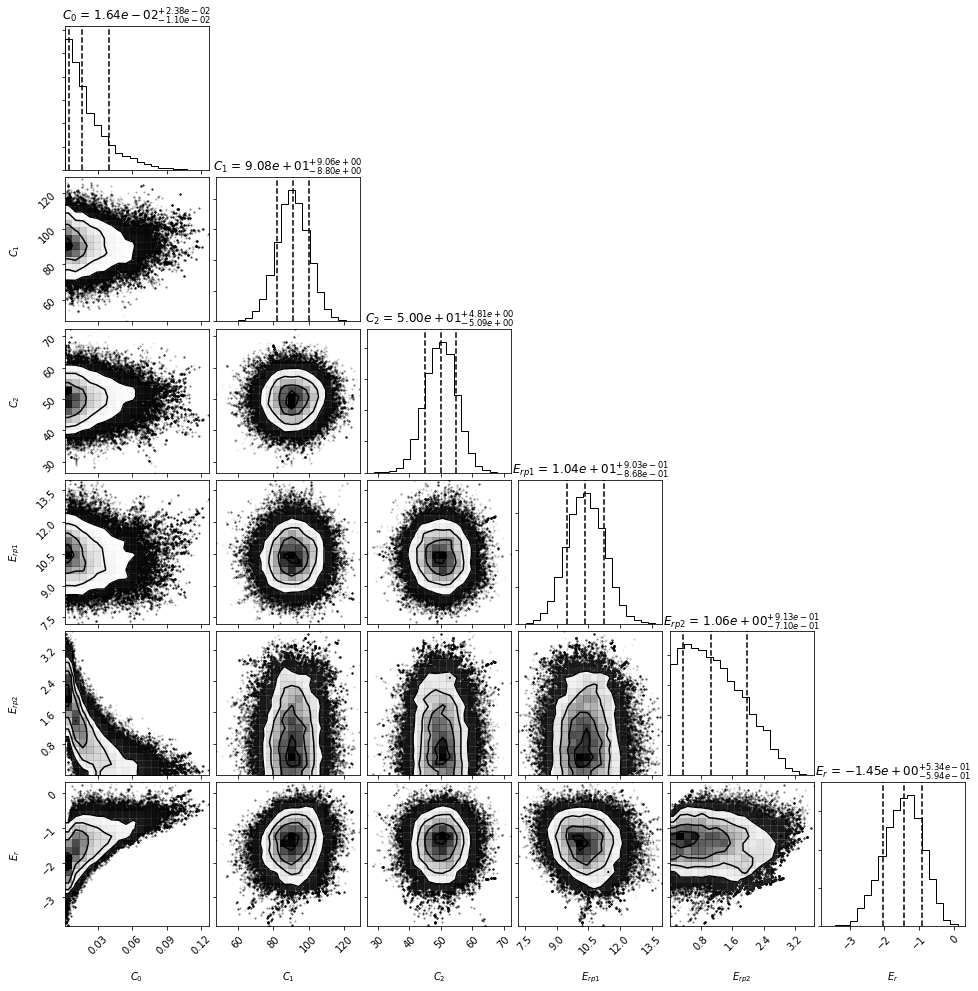

In [66]:
df = pd.DataFrame(samples4)
df.to_csv(path_or_buf='samplesout_heterodimerA.csv', sep=',')

df1 = pd.read_csv('samplesout_heterodimerA.csv', delimiter=',')

iterations = 10000
tburn = 500

data2 = np.zeros((df1.shape[0]-tburn*nwalkers)*(df1.shape[1]-1)).reshape((df1.shape[0]-(tburn*nwalkers)), (df1.shape[1]-1))


for i in range(0, int(df1.shape[1]-1)):
    for j in range(1, nwalkers+1):
        data2[(iterations - tburn)*(j - 1):(iterations - tburn)*(j),i]=np.array(df1.iloc[iterations*j - iterations + tburn: iterations*j, i + 1])
        
parameternames = ["$C_0$", "$C_1$", "$C_2$", "$E_{rp1}$", "$E_{rp2}$", "$E_r$"]

fig = corner.corner(data2, 
                    labels=parameternames, 
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, 
                    title_fmt='.2e', 
                    title_kwargs={"fontsize": 12},
                    verbose=True)

#plt.savefig('heterodimerA_corner.pdf',dpi=150,transparent=True, bbox_inches='tight')
plt.show()

Quantiles:
[(0.16, 0.0034697631972989327), (0.5, 0.005651179197443458), (0.84, 0.00929192568665805)]
Quantiles:
[(0.16, 320.82025684645043), (0.5, 528.9047919530753), (0.84, 855.5548418461462)]
Quantiles:
[(0.16, 9.921726652638489), (0.5, 15.34519669881686), (0.84, 23.16658341628026)]


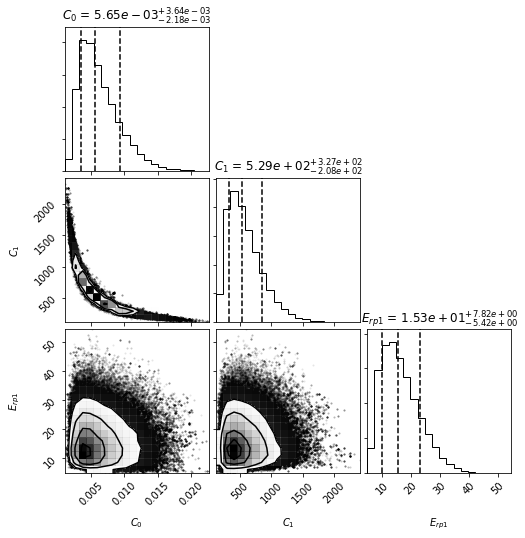

In [37]:
df = pd.DataFrame(samples1)
df.to_csv(path_or_buf='samplesout_heterodimerA1.csv', sep=',')

df1 = pd.read_csv('samplesout_heterodimerA1.csv', delimiter=',')

iterations = 10000
tburn = 500

data2 = np.zeros((df1.shape[0]-tburn*nwalkers)*(df1.shape[1]-1)).reshape((df1.shape[0]-(tburn*nwalkers)), (df1.shape[1]-1))


for i in range(0, int(df1.shape[1]-1)):
    for j in range(1, nwalkers+1):
        data2[(iterations - tburn)*(j - 1):(iterations - tburn)*(j),i]=np.array(df1.iloc[iterations*j - iterations + tburn: iterations*j, i + 1])
        
parameternames = ["$C_0$", "$C_1$", "$E_{rp1}$"]

fig = corner.corner(data2, 
                    labels=parameternames, 
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, 
                    title_fmt='.2e', 
                    title_kwargs={"fontsize": 12},
                    verbose=True)

#plt.savefig('heterodimerA_corner.pdf',dpi=150,transparent=True, bbox_inches='tight')
plt.show()